# Handwritten Mathematical Expressions Recognition
### Khiem T. Do, Phuong T.M. Chu & Santhos

In this notebook, we demonstrate how to perform the calculation with our Handwritten Mathematical Expressions Recognition models.

In [1]:
import cv2
import mahotas
import imutils
import numpy as np
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from skimage.feature import hog
import tensorflow as tf
import cv2 as cv2

%matplotlib inline

/home/reichu2/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
from skimage import feature

class HOG:
    def __init__(self, orientations=9, pixels_per_cell=(8,8), cells_per_block=(3,3), transform=False):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.transform = transform

    def describe(self, image):
        hist = feature.hog(image,
            orientations=self.orientations,
            pixels_per_cell=self.pixels_per_cell,
            cells_per_block=self.cells_per_block,
            transform_sqrt=self.transform)
        return hist

In [3]:
def deskew(image, width):
    (h, w) = image.shape[:2]
    moments = cv2.moments(image)

    skew = moments['mu11'] / moments['mu02']
    M = np.float32([[1, skew, -0.5*w*skew],
                    [0, 1, 0]])
    image = cv2.warpAffine(image, M, (w, h), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)

    image = imutils.resize(image, width=width)

    return image

def center_extent(image, size):
    (eW, eH) = size

    if image.shape[1] > image.shape[0]:
        image = imutils.resize(image, width=eW)
    else:
        image = imutils.resize(image, height=eH)

    extent = np.zeros((eH, eW), dtype='uint8')
    offsetX = (eW - image.shape[1]) // 2
    offsetY = (eH - image.shape[0]) // 2
    extent[offsetY:offsetY + image.shape[0], offsetX:offsetX+image.shape[1]] = image

    CM = mahotas.center_of_mass(extent)
    (cY, cX) = np.round(CM).astype("int32")
    (dX, dY) = ((size[0]//2) - cX, (size[1] // 2) - cY)
    M = np.float32([[1, 0, dX], [0, 1, dY]])
    extent = cv2.warpAffine(extent, M, size)

    return extent

In [4]:
# Loading models
## Model for handwritten digits
model_digit = tf.keras.models.load_model('handwritten_model.h5')

## Model for handwritten operators
model_operator = joblib.load("model_cls_operator.pkl")

labels_name = ['*', '+', '-', 'div']

W0909 14:01:29.918827 139914334095168 deprecation.py:323] From /home/reichu2/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
hog_1 = HOG(orientations=18, pixels_per_cell=(10,10), cells_per_block=(1,1), transform=True)

In [16]:
# Input image data
image = cv2.imread('test.png')

# Preprocess the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

blurred = cv2.GaussianBlur(gray, (5,5), 0)

edged = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 4)

(cnts, _) = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cnts = sorted([(c, cv2.boundingRect(c)[0]) for c in  cnts], key=lambda x: x[1])

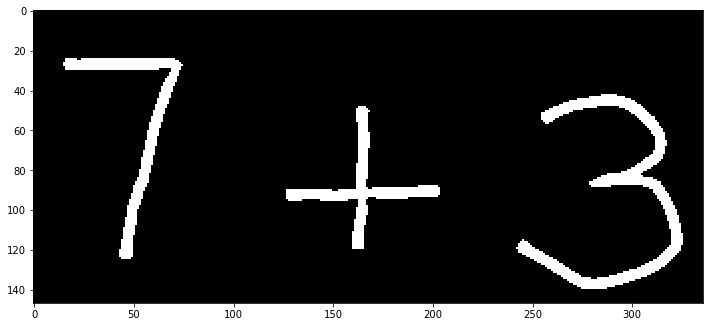

In [17]:
plt.figure(figsize=(12,8))
plt.imshow(imutils.opencv2matplotlib(edged))
plt.show()

In [18]:
def extract_hog(features):
    list_hog_fd = []
    for feature in features:
        fd = hog(feature.reshape((28, 28)), orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualize=False)
        list_hog_fd.append(fd)
    hog_features = np.array(list_hog_fd, 'float64')
    return hog_features

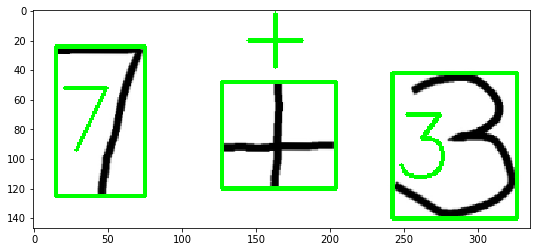

The result is: 10


In [19]:
plt.figure(figsize=(10,4))
s=""

for index, (c, _) in enumerate(cnts):
    (x, y, w, h) = cv2.boundingRect(c)

    if w >=7 and h>=20:
        roi = gray[y:y+h, x:x+w]
        thresh = roi.copy()
        T = mahotas.thresholding.otsu(roi)
        thresh[thresh > T] = 255
        thresh = cv2.bitwise_not(thresh)

        thresh_digit = deskew(thresh, 28)
        thresh_digit = center_extent(thresh_digit, (28,28))
        
        thresh_operator = deskew(thresh, 28)
        thresh_operator = center_extent(thresh_operator, (28,28))


        predictions_digit = model_digit.predict(np.expand_dims(thresh_digit, axis=0))
        predictions_operator = model_operator.predict(extract_hog(np.reshape(thresh_operator, (1, -1))))
        
        digits = np.argmax(predictions_digit[0])

        cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,0), 2)
         
        
        if index % 2 == 0:
            cv2.putText(image, str(digits), (x,y+70), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 2)
            s = s+str(digits)

        else:
            cv2.putText(image, labels_name[predictions_operator[0]], (x+10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 2)
            s = s+labels_name[predictions_operator[0]]
            
plt.imshow(imutils.opencv2matplotlib(image))
plt.show()
print("The result is:",eval(s))